# This is the analysis behind San Francisco Bike Share Program.

In [2]:
%matplotlib inline
import sqlite3
from pandasql import sqldf
import pandas as pd
import matplotlib.pyplot as plt

# df_trip_data_part1 = pd.read_sql_query("""
#                           select * from fact_trips 
#                           left join dim_stations on
#                           fact_trips.start_station_id = dim_stations.id
#                           left join (select * from dim_stations) as dim_stations_end on
#                           fact_trips.end_station_id = dim_stations_end.id
#                           left join (select id, entity_type as Subscriber_Type from dim_entity) as subscriber on
#                           fact_trips.entity_id = subscriber.id
#                           left join (select entity_id, zip_code from dim_entity_zip) as entity_zip_a on
#                           fact_trips.entity_id = entity_zip_a.entity_id
#                           ;
#                           """, 
#                           conn)

df = pd.io.parsers.read_csv('201408_trip_data.csv', dtype={'Zip Code': 'str'})
df['Start Date'] = pd.to_datetime(df['Start Date'])
df['End Date'] = pd.to_datetime(df['End Date'])
df['Start Day of Week'] = df['Start Date'].dt.strftime('%A')
df['End Day of Week'] = df['End Date'].dt.strftime('%A')
df['Start Hour'] = df['Start Date'].dt.strftime('%H')
df['End Hour'] = df['End Date'].dt.strftime('%H')
df['Duration_parsed'] = pd.to_timedelta(df['Duration'], unit='m')
df['Route'] = df['Start Station'] + "-" + df['Start Terminal'].astype(str) + " -> " + df['End Station'] + "-" + df['End Terminal'].astype(str)
df.head()
df.apply(pd.Series.nunique)

Trip ID              171792
Duration               8329
Start Date            93171
Start Station            70
Start Terminal           70
End Date              92115
End Station              70
End Terminal             70
Bike #                  681
Subscriber Type           2
Zip Code               3526
Start Day of Week         7
End Day of Week           7
Start Hour               24
End Hour                 24
Duration_parsed        8329
Route                  1677
dtype: int64

1132.51424979
Start Day of Week  Subscriber Type
Friday             Customer            4032
                   Subscriber         23238
Monday             Customer            3141
                   Subscriber         25876
Saturday           Customer            5811
                   Subscriber          5626
Sunday             Customer            6019
                   Subscriber          5066
Thursday           Customer            3387
                   Subscriber         27253
Tuesday            Customer            3134
                   Subscriber         27944
Wednesday          Customer            3386
                   Subscriber         27879
Name: Trip ID, dtype: int64


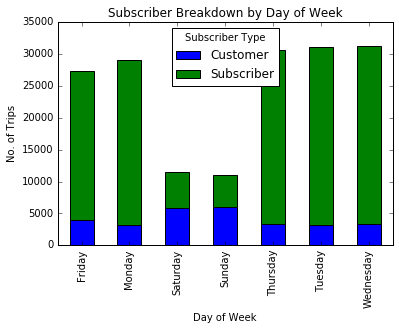

In [4]:
print df['Duration'].mean()



# Analysis/Commentary

We have a total of 70 unique terminals in this program. We have 171792 trips made over a span of 5 months, from March 2014 to August 2014. The average trip takes about 18 minutes


Busiest Stations:


Time/Day Analysis:
Weekdays vs Weekends
Implication? Should we increase or decrease capacity on weekdays or weekends




# Knowing our users

Subscriber Type
Customer       28910
Subscriber    142882
Name: Trip ID, dtype: int64
Start Day of Week  Subscriber Type
Friday             Customer            4032
                   Subscriber         23238
Monday             Customer            3141
                   Subscriber         25876
Saturday           Customer            5811
                   Subscriber          5626
Sunday             Customer            6019
                   Subscriber          5066
Thursday           Customer            3387
                   Subscriber         27253
Tuesday            Customer            3134
                   Subscriber         27944
Wednesday          Customer            3386
                   Subscriber         27879
Name: Trip ID, dtype: int64


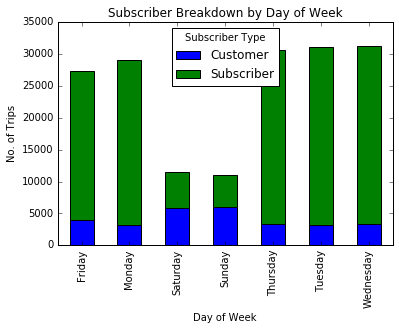

In [10]:
# plot user counts by subscriber type
user_breakdown = df.groupby(['Subscriber Type'])['Trip ID'].count()
print user_breakdown

# plot subscriber type vs day of week
day_of_week = df.groupby(['Start Day of Week', 'Subscriber Type'])['Trip ID'].count()
print day_of_week
day_of_week.unstack()
day_of_week_plot = day_of_week.unstack().plot(kind='bar',stacked=True,title="Subscriber Breakdown by Day of Week")
day_of_week_plot.set_xlabel("Day of Week")
day_of_week_plot.set_ylabel("No. of Trips")



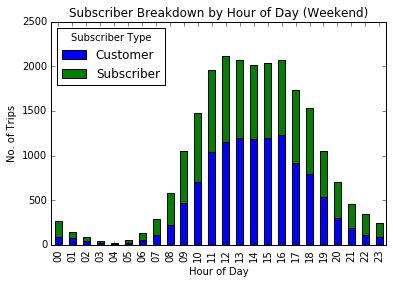

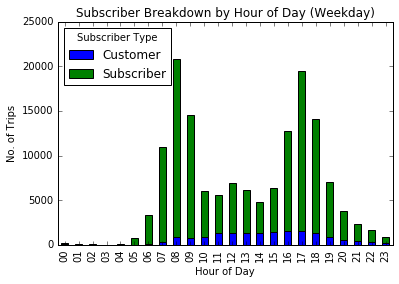

In [13]:
# plot subscriber type vs day of week (weekend)
weekend = ['Saturday', 'Sunday']
df_filter_weekend = df[df['Start Day of Week'].isin(weekend)]

hour_of_day_weekend = df_filter_weekend.groupby(['Start Hour', 'Subscriber Type'])['Trip ID'].count()
hour_of_day_weekend.unstack()
hour_of_day_weekend_plot = hour_of_day_weekend.unstack().plot(kind='bar',stacked=True,title="Subscriber Breakdown by Hour of Day (Weekend)")
hour_of_day_weekend_plot.set_xlabel("Hour of Day")
hour_of_day_weekend_plot.set_ylabel("No. of Trips")

# plot subscriber type vs day of week (weekday)
df_filter_weekday = df[~df['Start Day of Week'].isin(weekend)]

hour_of_day_weekday = df_filter_weekday.groupby(['Start Hour', 'Subscriber Type'])['Trip ID'].count()
hour_of_day_weekday.unstack()
hour_of_day_weekday_plot = hour_of_day_weekday.unstack().plot(kind='bar',stacked=True,title="Subscriber Breakdown by Hour of Day (Weekday)")
hour_of_day_weekday_plot.set_xlabel("Hour of Day")
hour_of_day_weekday_plot.set_ylabel("No. of Trips")

# Percentage share of customers vs subscribers 

17% of trips are from customers. The remaining 83% are from subscribers. We might want to obtain revenue data for customers and subscribers for deeper analysis into revenue generated from each group. Also, we don't know the percentage of new vs repeat customers, this may define the direction/priority for future customer acquisition or retention programs.

# Usage Trends

Customer usage peaks during weekends. In contrast, subscriber usage peaks during weekdays. This is valuable data for targeting different segments of users, be it via in-app push notifications, marketing campaigns, google adwords, re-marketing, and other data-driven campaigns. Of course, this could possibly have an effect on response rates for paid campaigns and/or ad spend.


Hour of day - weekends
Usage peaks during the day. This is true for both customers and subscribers. Ridership decreases during weekends. This may be an opportunity for to target different segments of users - possibly leisure riders (or perhaps they are already switching to using Uber on weekends!)

Hour of day - weekdays
Usage peaks during typical "rush hours" as expected - 7am - 9am, 4pm - 7pm

Such data would help for demand planning and forecasts to ensure sufficient bikes at the most popular terminals.

Check seasonality by month
Which zip codes do they come from
This has implications IP targeted campaigns - it could be possible to increase new customer/subscriber acquisition quickly by placing ads/content for people in the cities of frequently used terminals, then gradually move towards areas with fewer customers/subscribers.
Which terminals do they come from

#  Most frequently used stations

# Predictions/Recommendations

Can we predict ridership by seasonality

We saw here that Bike Share is used mostly in San Francisco, by commuters, when it isn't raining, for rides under 15 minutes. It looks like BART commuters don't use the system to the extent that Caltrain commuters do. On weekends and holidays, visitors to San Francisco use the system to ride around town.

One dimension not explored in this analysis was popularity of each station among subscribers vs customers. With what we saw of the behavior of customers vs subscribers we could identify stations more popular with tourists or with commuters and potentially identify areas of the city with demand for future stations.

One recommendation that can be made is for station growth into SOMA. Users are already shown to be commuters heading to work, and SOMA is one area of San Francisco with a high density of businesses, close proximity to the existing stations, and currently lacking any Bike Share stations.

Data we DON'T know
Public holidays Weather - intuition suggests that usage would plummet during rainy or inclement weather. Is this true, and how can we transform or add value to riders in poor weather conditions. What about sunny weather Type of bike - do we want to provide bike recommendations depending on types of trips. Road bikes might be better if its long distances. Powerful zipcode libraries not available for every country unlike in US.
REMOVE TRIPS NOT TO SF
sf <- c("South Van Ness at Market", "Market at 10th", "San Francisco City Hall", "Golden Gate at Polk", "Civic Center BART (7th at Market)", "Powell Street BART", "Powell at Post (Union Square)", "5th at Howard", "Market at 4th", "Post at Kearny", "Commercial at Montgomery", "Washington at Kearny", "Grant Avenue at Columbus Avenue", "Embarcadero at Sansome", "Embarcadero at Vallejo", "Broadway St at Battery St", "Davis at Jackson", "Clay at Battery", "Harry Bridges Plaza (Ferry Building)", "Steuart at Market", "Beale at Market", "Mechanics Plaza (Market at Battery)", "Embarcadero at Folsom", "Temporary Transbay Terminal (Howard at Beale)", "Market at Sansome", "Spear at Folsom", "Howard at 2nd", "Embarcadero at Bryant", "Yerba Buena Center of the Arts (3rd @ Howard)", "2nd at Folsom", "2nd at South Park", "2nd at Townsend", "San Francisco Caltrain (Townsend at 4th)", "Townsend at 7th", "San Francisco Caltrain 2 (330 Townsend)")